# Dino or Dragon Version-2

In the notebook, we'll deploy the dino or dragon model we trained in the session 8.

Download the model from here:

https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the **converted** model?

- 21 Mb
- 43 Mb
- 80 Mb
- 164 Mb

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow import keras

In [2]:
# Load keras model
model = keras.models.load_model('dino_dragon_10_0.899.h5')

In [3]:
# Initialize tflite converter from keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Make conversion to tflite model
tflite_model = converter.convert()

# Save the model in tflite format
with open('dino-dragon-model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\awon\AppData\Local\Temp\tmphdipzwem\assets


INFO:tensorflow:Assets written to: C:\Users\awon\AppData\Local\Temp\tmphdipzwem\assets


In [4]:
# Check the saved model and its size
!ls -lh

total 129M
drwxr-xr-x 1 awon 197121    0 Nov 22 19:05 __pycache__
-rw-r--r-- 1 awon 197121  43M Nov 22 20:54 dino-dragon-model.tflite
-rw-r--r-- 1 awon 197121  83K Nov 22 20:54 dino-or-dragon-v2.ipynb
-rw-r--r-- 1 awon 197121  86M Nov 22 13:45 dino_dragon_10_0.899.h5
-rw-r--r-- 1 awon 197121 2.1K Nov 22 19:05 lambda_function.py
-rw-r--r-- 1 awon 197121  292 Nov 22 17:36 test.py


## Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

- 3
- 7
- 13
- 24

In [5]:
# Instantiate model using interpreter class
interpreter = tflite.Interpreter(model_path='dino-dragon-model.tflite')

# Load the weights from the model to memory
interpreter.allocate_tensors()


In [6]:
# Get the input and output index from the interpreter
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

# Output index
output_index

13

## Preparing the Image

We'll need some code for downloading and resizing images. We can use the following code:

In [7]:
from io import BytesIO
from urllib import request
from PIL import Image
from PIL.Image import Resampling

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, resample=Resampling.NEAREST)
    return img


# Function to rescale image input
def rescale_img(x):
    return x / 255.0

To make the above function to work, we'll need to have `pillow` installed `pip install pillow` (if already not installed).

Let's download and resize this image:

https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg

We'll set the target size for the image as we did in the session 8 (i.e, 150 x 150).

## Question 3

Now we need to turn the image into numpy array and preprocess it.

After the preprocessing, what's the value in the first pixel, the R channel?

- 0.3353411
- 0.5529412
- 0.7458824
- 0.9654902

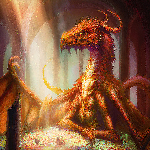

In [8]:
# Load image from url
img = download_image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg')

# Prepare image by sizing it to (150, 150)
img = prepare_image(img=img, target_size=(150, 150))
img

In [9]:
# Convert the image into numpy array
x = np.array(img, dtype='float32')
# Add batch dimension into image array
X = np.array([x])

# Rescale image
X = rescale_img(X)

In [10]:
# R value in the first pixel in color channel
X[0, 0, 0, 0]

0.5529412

## Question 4

Now let's apply this model to this image. What's the output of the model?

- 0.17049132
- 0.39009996
- 0.60146114
- 0.82448614

In [11]:
# Make image prediction using tflite model
interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)[0][0]
pred

0.8244853

### Prepare the Lambda Code

Now we need to copy all of the code into separate python file. We will need to use this file for the next two questions.

Tip: We can test this file locally with `ipython` or Jupyter Notebook by importing the file and invoking the function from this file.

### Docker

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

```dockerfile
FROM public.ecr.aws/lambda/python:3.9
COPY dino-vs-dragon-v2.tflite .
```

And pushed it to [svizor42/zoomcamp-dino-dragon-lambda:v2](https://hub.docker.com/r/svizor42/zoomcamp-dino-dragon-lambda/tags).

> Note: The image already contains a model and it's not the same model as the one we used for questions 1-4.


## Question 5

Download the base image `svizor42/zoomcamp-dino-dragon-lambda:v2`. We can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

- 139 Mb
- 329 Mb
- 639 Mb
- 929 Mb

We can get this information when running `docker images` - it'll be in the "SIZE" column.

## Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

We don't need to include the model in the image. It's already included. The name of the file with the model is `dino-vs-dragon-v2.tflite` and it's in the current workdir in the image (see the Dockerfile above for the reference).

Now run the container locally.

Score this image:
https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg

What's the output from the model?

- 0.12
- 0.32
- 0.52
- 0.72

### Publishing it to AWS

Now we can deploy our model to AWS!

- Publish our image to ECR
- Create a lambda function in AWS, use the ECR image
- Give it more RAM and increase the timeout
- Test it
- Expose the lambda function using API Gateway

This is optional and not graded.

### Publishing to Docker Hub

This is just for reference, this is how we published our image to Docker hub:

```bash
docker build -t zoomcamp-dino-dragon-lambda .
docker tag zoomcamp-dino-dragon-lambda:latest svizor42/zoomcamp-dino-dragon-lambda:v2
docker push svizor42/zoomcamp-dino-dragon-lambda:v2
```

